## 필요 데이터

In [65]:
import pandas as pd
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

df = pd.read_csv('./data/카카오(eng).csv')  #제목+본문 데이터를 구글번역기로 번역한 파일 불러오기
df.isna().sum() # 종토방 영어번역 결측치 확인
df

,full date,Item name,all
0,2022.06.01 05:23,cacao,"At this time, the main KAKAO is swept away by ..."
1,2022.06.01 08:44,cacao,get a lot of money and it's dissatisfying that...
2,2022.06.01 08:59,cacao,Grandpa Yoo Young-doo is very disappointing~~^...
3,2022.06.01 09:29,cacao,"I don't know what he's doing, but he's trying ..."
4,2022.06.01 09:37,cacao,An unwritten Yankee puppet who wants to fight ...
...,...,...,...
6615,2022.06.30 23:31,cacao,If you see this and think that Seok-Yeol Yoon ...
6616,2022.06.30 23:34,cacao,I can't sleep. How much will I be stuck in the...
6617,2022.06.30 23:40,cacao,I wonder what the average price was before thi...
6618,2022.06.30 23:52,cacao,"7,000 on Nasdaq. KAKAO goes 30,000. haha"


In [66]:
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

list = []   # 빈 리스트 생성
for index, row in df.iterrows():
    list.insert(0, sia.polarity_scores(row['all']))     

df2 = pd.DataFrame(data = list, columns=['neg', 'neu', 'pos', 'compound'], index=df.index)    
df2.isna().sum() # 감성분석 수치 결측치 확인
df2

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\subin\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,neg,neu,pos,compound
0,0.000,0.903,0.097,0.0762
1,0.000,0.667,0.333,0.4588
2,0.000,1.000,0.000,0.0000
3,0.143,0.857,0.000,-0.2500
4,0.344,0.656,0.000,-0.9001
...,...,...,...,...
6615,0.206,0.754,0.040,-0.9873
6616,0.000,0.750,0.250,0.7684
6617,0.178,0.703,0.119,-0.4810
6618,0.169,0.753,0.078,-0.7216


## 날짜&시간별 종토방 감성분석

In [67]:
df2 = df2.reset_index().rename(columns={"index":"index"})   


## 데이터 합치기: 종토방 데이터 + 감성분석
df3 = pd.read_csv('./data/카카오(kor).csv')                 
df3 = df3.reset_index().rename(columns={"index":"index"})   

df4 = pd.merge(df3, df2, on="index", how="left")            
df4.drop(['index'], axis = 1, inplace=True)                 


## 시간데이터 정제
a = df4.copy()
a['날짜'] = pd.to_datetime(a['전체날짜']).dt.date
a['시간'] = pd.to_datetime(a['전체날짜']).dt.time
a = a[['전체날짜', '날짜','시간', '종목명', '전체', 'neg', 'neu', 'pos', 'compound']]

# 시간별로 나누기 위해
a['시간'] = a['시간'].astype(str)
a['시간'] = a['시간'].str.replace(":","")
a['시간'] = a['시간'].astype(int)
a['시간'] = a['시간'] / 100
a['시간'] = a['시간'].astype(int)


# 한시간 단위로 데이터 분리위해
def test(b):
    if b <= 900:
        return '09:00:00'
    if b <= 1000:
        return '10:00:00'
    if b <= 1100:
        return '11:00:00'
    if b <= 1200:
        return '12:00:00'
    if b <= 1300:
        return '13:00:00'
    if b <= 1400:
        return '14:00:00'
    if b <= 1500:
        return '15:00:00'
    if b <= 1600:
        return '16:00:00'

a['시간변환'] = a['시간'].apply(test)


# 종토방 + 감성분석 + 주가 데이터 합치는 과정
df5 = pd.read_excel('./data/kakao_price.xlsx', sheet_name= '카카오_시간별 종가')     # 시간별 종가 불러오기
df6 = pd.read_excel('./data/kakao_price.xlsx', sheet_name= '카카오_일별 종가')     # 일별 종가 불러오기
df7 = pd.concat([df5,df6], ignore_index=True)   # 시간별, 일별 종가 합치기
df7.sort_values(by='일시', ignore_index=True, inplace=True )    # 일시 기준으로 정렬

# 종토방 데이터랑 합치기 위해 주가 데이터 변환
pr = df7.copy()
pr['날짜'] = pd.to_datetime(pr['일시']).dt.date
pr['시간'] = pd.to_datetime(pr['일시']).dt.time
pr['시간'] = pr['시간'].astype(str)
pr = pr.rename(columns={'시간' : '시간변환'})
pr = pr[['날짜', '시간변환', '종가']]

# 종토방 + 주가 데이터 합치기
data = pd.merge(a, pr, how='inner', on=['시간변환', '날짜'])
data.drop(['시간'], axis=1, inplace=True)


d = data.set_index(['날짜', '시간변환'])    #날짜, 시간별 데이터 정렬
# d.loc['2022-06-02', '09:00:00']     # 특정 시간 선택해서 데이터 추출
d

전체날짜  종목명  \
날짜         시간변환                              
2022-06-02 09:00:00  2022.06.02 01:45  카카오   
           09:00:00  2022.06.02 01:54  카카오   
           09:00:00  2022.06.02 08:06  카카오   
           09:00:00  2022.06.02 08:17  카카오   
           09:00:00  2022.06.02 08:19  카카오   
...                               ...  ...   
2022-06-30 16:00:00  2022.06.30 15:48  카카오   
           16:00:00  2022.06.30 15:48  카카오   
           16:00:00  2022.06.30 15:48  카카오   
           16:00:00  2022.06.30 15:54  카카오   
           16:00:00  2022.06.30 15:59  카카오   

                                                                    전체    neg  \
날짜         시간변환                                                                 
2022-06-02 09:00:00  내가 말했재??KAKAO는 너무 씹거품이라고 네이버사라고 ㅋㅋㅋ\n\n네이버는 살만...  0.000   
           09:00:00  KAKAO 주가 전망 및 분석ddomi.tistory.com/43\n\n객관적인 분...  0.000   
           09:00:00  오늘 압축 영화의 재미는,,,,//이번 선거는 이재명 죽이기\n\n경기도 이재명 흔...  0.000   
           09:00:00  성탄절이 토요일, 일요일일 경우 월요일을 대체공휴일로 지정해주세요.성탄절이 토요일,...  0.103   
           09:00:00          두번째 물어봅니다...평단 9만원 1000주 피가 마릅니다....오나요?ㅠ  0.160   
...                                                                ...    ...   
2022-06-30 16:00:00                   시장연기금은 엄청나게 팔어 외국인은 사고 싼 가격 안아닌가  0.000   
           16:00:00  김범수가그랬지 액면분할해서 모든국민이 KAKAO주식을 가질수 있도록~~ ㅋㅋㅋ 주주...  0.000   
           16:00:00                         적정가 3만원앙꼬빠진 껍데기 주식..아직도 거품  0.000   
           16:00:00  액면가 100원으로 분할해서개미들이 고가에\n다받아 먹고\n설거지중입니다\n적정주가...  0.000   
           16:00:00  이야기했지살짝 올려서 개미한테 넘기는거라고 ㅋㅋ추격매수한것들 알아서 처신해라ㆍㆍ한강...  0.000   

                       neu    pos  compound     종가  
날짜         시간변환                                     
2022-06-02 09:00:00  1.000  0.000    0.0000  83300  
           09:00:00  0.593  0.407    0.5859  83300  
           09:00:00  1.000  0.000    0.0000  83300  
           09:00:00  0.871  0.026   -0.8895  83300  
           09:00:00  0.840  0.000   -0.2732  83300  
...                    ...    ...       ...    ...  
2022-06-30 16:00:00  1.000  0.000    0.0000  69900  
           16:00:00  0.674  0.326    0.4404  69900  
           16:00:00  1.000  0.000    0.0000  69900  
           16:00:00  0.638  0.362    0.8176  69900  
           16:00:00  1.000  0.000    0.0000  69900  

[5037 rows x 8 columns]

## 감성분석 수치별 점수화

In [68]:
# 날짜/시간대 별 감성분석 평균값
d = d.copy()
d.groupby(["날짜", "시간변환"])['compound'].mean()

import numpy as np
# compound(종합감성분석)의 날짜/시간대 별 평균값
dd = d.groupby(["날짜", "시간변환"])['compound'].apply(np.average)
dd = pd.DataFrame(dd)


# 강한 부정을 -2로 표기: 복합 점수가 -0.5보다 적을 때, 즉 점수 < -0.5
# 약한 부정을 -1로 표기: 복합 점수가 -0.5보다 같거나 크고 0보다 작을 때, 즉 -0.5 <= 점수 < 0 
# 중립을 0으로 표기: 복합 점수가 0일 때, 즉 점수 = 0
# 약한 긍정을 1로 표기: 복합 점수가 0보다 크고 0.5보다 같거나 작을 때, 즉 0 < 점수 <= 0.5
# 강한 긍정을 2로 표기: 복합 점수가 0.5를 초과할 때, 즉 점수 > 0.5

def compound(c):
    if c < -0.5:
        return '-2'
    if -0.5 <= c < 0:
        return '-1'
    if c == 0:
        return '0'
    if 0 < c <= 0.5:
        return '1'
    if c > 0.5:
        return '2'
    
dd['점수변환'] = dd['compound'].apply(compound)
dd

compound 점수변환
날짜         시간변환                   
2022-06-02 09:00:00 -0.023962   -1
           10:00:00  0.112439    1
           11:00:00  0.159000    1
           12:00:00 -0.492033   -1
           13:00:00 -0.047057   -1
...                       ...  ...
2022-06-30 12:00:00  0.400167    1
           13:00:00 -0.289233   -1
           14:00:00  0.359688    1
           15:00:00  0.251736    1
           16:00:00  0.109861    1

[160 rows x 2 columns]

## 감성분석 수치와 시간별 주가변동

In [69]:
# 변동률
v = df7.copy()
for df in v:
    v['전시간종가'] = v['종가'].shift() 
    v['전시간대비변동가격'] = v['종가'] - v['전시간종가']
    v['전시간기준등락율'] = ((v['종가'] - v['전시간종가'])/v['전시간종가']) * 100  


# 종토방 데이터랑 합치기 위해 주가 데이터 변환
vv = v.copy()
vv['날짜'] = pd.to_datetime(vv['일시']).dt.date
vv['시간'] = pd.to_datetime(vv['일시']).dt.time
vv['시간'] = vv['시간'].astype(str)
vv = vv.rename(columns={'시간' : '시간변환'})
vv = vv[['날짜', '시간변환', '종가', '전시간종가', '전시간대비변동가격', '전시간기준등락율']]
vv = vv.set_index(['날짜', '시간변환'])    #날짜, 시간별 데이터 정렬
vv

종가    전시간종가  전시간대비변동가격  전시간기준등락율
날짜         시간변환                                         
2022-06-02 09:00:00  83300      NaN        NaN       NaN
           10:00:00  83600  83300.0      300.0  0.360144
           11:00:00  83500  83600.0     -100.0 -0.119617
           12:00:00  83400  83500.0     -100.0 -0.119760
           13:00:00  83500  83400.0      100.0  0.119904
...                    ...      ...        ...       ...
2022-06-30 12:00:00  70200  70400.0     -200.0 -0.284091
           13:00:00  70100  70200.0     -100.0 -0.142450
           14:00:00  70100  70100.0        0.0  0.000000
           15:00:00  69900  70100.0     -200.0 -0.285307
           16:00:00  69900  69900.0        0.0  0.000000

[160 rows x 4 columns]

In [70]:
# compound(평균값) + 등락률 데이터 합치기
dv = pd.merge(dd, vv, how='inner', on=['날짜', '시간변환'])
dv.isna().sum() # 결측치 확인
dv.dropna(inplace=True) # 결측치 제거
dv

compound 점수변환     종가    전시간종가  전시간대비변동가격  전시간기준등락율
날짜         시간변환                                                        
2022-06-02 10:00:00  0.112439    1  83600  83300.0      300.0  0.360144
           11:00:00  0.159000    1  83500  83600.0     -100.0 -0.119617
           12:00:00 -0.492033   -1  83400  83500.0     -100.0 -0.119760
           13:00:00 -0.047057   -1  83500  83400.0      100.0  0.119904
           14:00:00  0.205371    1  83600  83500.0      100.0  0.119760
...                       ...  ...    ...      ...        ...       ...
2022-06-30 12:00:00  0.400167    1  70200  70400.0     -200.0 -0.284091
           13:00:00 -0.289233   -1  70100  70200.0     -100.0 -0.142450
           14:00:00  0.359688    1  70100  70100.0        0.0  0.000000
           15:00:00  0.251736    1  69900  70100.0     -200.0 -0.285307
           16:00:00  0.109861    1  69900  69900.0        0.0  0.000000

[159 rows x 6 columns]

In [71]:
df3 = pd.read_csv('./data/카카오(kor).csv')     #제목+본문 한글 데이터 파일 불러오기
dv.isna().sum() # 결측치 확인
dv.dropna(inplace=True) # 결측치 제거
dv

compound 점수변환     종가    전시간종가  전시간대비변동가격  전시간기준등락율
날짜         시간변환                                                        
2022-06-02 10:00:00  0.112439    1  83600  83300.0      300.0  0.360144
           11:00:00  0.159000    1  83500  83600.0     -100.0 -0.119617
           12:00:00 -0.492033   -1  83400  83500.0     -100.0 -0.119760
           13:00:00 -0.047057   -1  83500  83400.0      100.0  0.119904
           14:00:00  0.205371    1  83600  83500.0      100.0  0.119760
...                       ...  ...    ...      ...        ...       ...
2022-06-30 12:00:00  0.400167    1  70200  70400.0     -200.0 -0.284091
           13:00:00 -0.289233   -1  70100  70200.0     -100.0 -0.142450
           14:00:00  0.359688    1  70100  70100.0        0.0  0.000000
           15:00:00  0.251736    1  69900  70100.0     -200.0 -0.285307
           16:00:00  0.109861    1  69900  69900.0        0.0  0.000000

[159 rows x 6 columns]

# 상관관계 분석

In [72]:
# compound와 전시간기준등락율의 상관관계
dv_corr = dv['compound'].corr(dv['전시간기준등락율'])
dv_corr

# 결과 : 0.019613025798778962

#####################################################

0.019613025798778962

In [73]:
# compound와 전시간기준등락율의 공분산
dv_cor = dv['compound'].cov(dv['전시간기준등락율'])
dv_cor

0.002449114244804781

c:\Users\subin\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\subin\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


<AxesSubplot:>

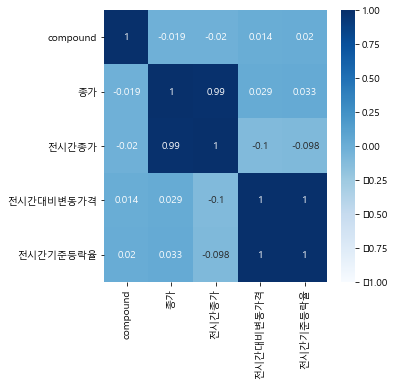

In [74]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (5,5)
plt.rcParams['font.family'] = 'Malgun Gothic'

sns.heatmap(dv.corr(),
           annot = True, #실제 값 화면에 나타내기
           cmap = 'Blues', #색상
           vmin = -1, vmax=1 , #컬러차트 영역 -1 ~ +1
          )

<AxesSubplot:>

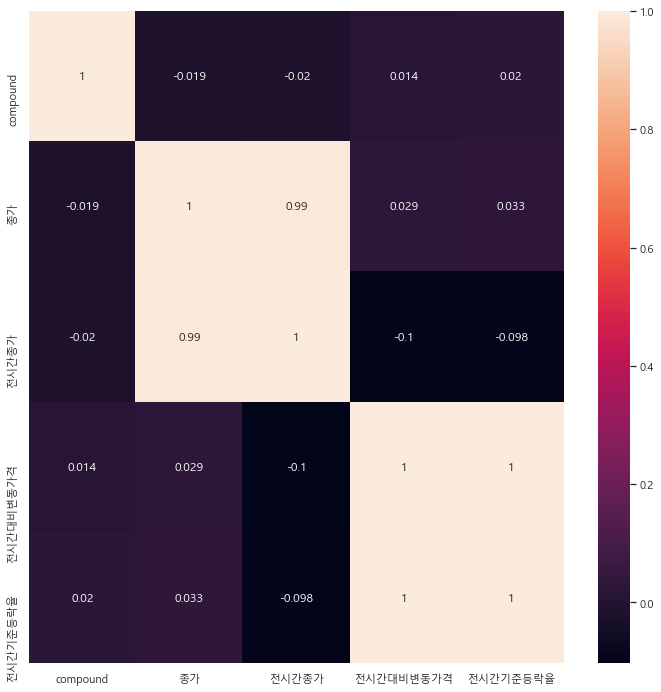

In [75]:
sns.set(rc={'figure.figsize':(12,12)})
sns.set(font="Malgun Gothic")

sns.heatmap(dv.corr(), annot=True)